In [5]:
from fore_utils import *

In [ ]:
import torch
import torch.nn as nn
    
class TransformerModel_Point(nn.Module):
    def __init__(self, window_size: int = 24, variables: int = 6, spaces: int = 0, d_model=64, nhead=8, num_layers=8, output_dim: int = 12):
        super(TransformerModel_Point, self).__init__()

        input_dim = window_size * variables * spaces

        self.encoder = nn.Linear(input_dim, d_model)

        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, batch_first=True)

        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)

        self.decoder = nn.Linear(d_model, output_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        # print(x.shape)

        x = self.encoder(x)
        # print(x.shape)

        x = x.unsqueeze(1) 
        
        x = self.transformer_encoder(x)
        # print(x.shape)

        x = self.decoder(x.squeeze(1))
        # print(x.shape)
        
        return x
    
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim: int = 6, hidden_dim: int = 64, num_layers: int = 2, output_dim: int = 24):
        super(SimpleLSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # LSTM expects input of shape (batch_size, seq_len, input_dim)
        _, (hn, _) = self.lstm(x)  # hn is the hidden state from the last LSTM layer
        
        # Take the last hidden state and pass through the fully connected layer
        x = self.fc(hn[-1])  # Shape: [batch_size, output_dim]
        return x


class SimpleMLP(nn.Module):
    def __init__(self, window_size: int = 5, variables: int = 6, hidden_dim: int = 128, output_dim: int = 24):
        super(SimpleMLP, self).__init__()
        
        input_dim = window_size * variables  # Flattened input dimension
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)  # Shape: [batch_size, window_size * variables]
        
        # Pass through the fully connected layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # Final output layer with output_dim neurons
        return x

class EnsembleForecastingModel(nn.Module):
    def __init__(self, window_size: int = 5, variables: int = 6, spaces: int = 1, d_model=64, nhead=8, num_layers=8, output_dim: int = 24, hidden_dim: int = 128):
        super(EnsembleForecastingModel, self).__init__()
        
        # Initialize individual models
        self.transformer_model = TransformerModel_Point(window_size=window_size, variables=variables, spaces=spaces, d_model=d_model, nhead=nhead, num_layers=num_layers, output_dim=output_dim)
        self.lstm_model = SimpleLSTM(input_dim=variables, hidden_dim=hidden_dim, num_layers=2, output_dim=output_dim)
        self.mlp_model = SimpleMLP(window_size=window_size, variables=variables, hidden_dim=hidden_dim, output_dim=output_dim)
        
        # Optional learnable weights for each model
        self.weights = nn.Parameter(torch.ones(3))  # One weight per model
    
    def forward(self, x):
        # Get predictions from each model
        transformer_output = self.transformer_model(x)
        lstm_output = self.lstm_model(x)
        mlp_output = self.mlp_model(x)
        
        # Stack outputs for weighted average
        outputs = torch.stack([transformer_output, lstm_output, mlp_output], dim=0)  # Shape: [3, batch_size, output_dim]
        
        # Normalize weights and compute weighted sum
        normalized_weights = torch.softmax(self.weights, dim=0)
        ensemble_output = (normalized_weights.view(-1, 1, 1) * outputs).sum(dim=0)  # Shape: [batch_size, output_dim]
        
        return ensemble_output


In [9]:
window_size = 5
steps = 24
spaces = 0
hidden_size = 32
batch_size = 64
n_heads = 4
num_layers = 8
series_target = True
lightning = False
verbose = True

config = {
    "hidden_layer_sizes": [hidden_size],
    "window_size" : [window_size],
    "step_size" : [steps],
    "spaces" : [spaces],
    "batch_size": [batch_size],
    "n_heads": [n_heads],
    "num_layers": [num_layers],
    "series_target": [series_target],
    "lightning": [lightning],
}

train_set = WeatherData(window_size=window_size, step_size=steps, set='train', spaces=spaces, lightning=lightning, series_target=series_target, verbose=verbose)
train_loader = DataLoader(train_set,
                           batch_size=batch_size, shuffle=True)
    
val_set = WeatherData(window_size=window_size, step_size=steps, set='val', spaces=spaces, lightning=lightning, series_target=series_target, verbose=verbose)
val_loader = DataLoader(val_set,
                           batch_size=batch_size, shuffle=False)


Details for train set:
Data from ['2018', '2019', '2020', '2021'] loaded
Features shape: torch.Size([35064, 6])
Targets shape: torch.Size([35064])
Longitudes: 18.3061580657959
Latitudes: -31.636999130249023
Details for val set:
Data from ['2022'] loaded
Features shape: torch.Size([8760, 6])
Targets shape: torch.Size([8760])
Longitudes: 18.3061580657959
Latitudes: -31.636999130249023


Input shape: torch.Size([64, 5, 6])
Target shape: torch.Size([64, 24])
Prediction shape: torch.Size([64, 24])
torch.Size([64, 5])


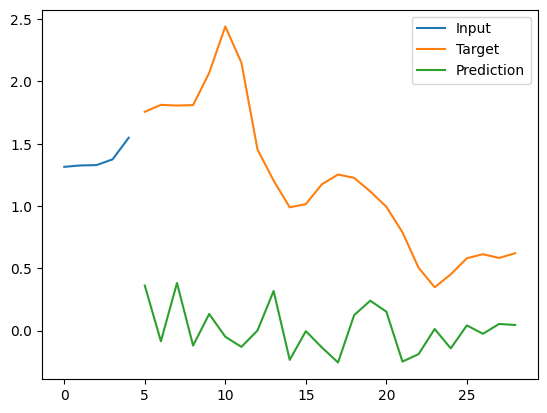

In [ ]:
for batch in train_loader:
    x,b, y = batch
    break

# model = TransformerModel_Point(window_size=window_size, 
#                             variables=6, 
#                             spaces=1, 
#                             d_model=hidden_size, 
#                             nhead=n_heads, 
#                             num_layers=num_layers, 
#                             output_dim=steps)

# model = SimpleLSTM(input_dim=window_size, 
#                    hidden_dim=hidden_size, 
#                    num_layers=num_layers, 
#                    output_dim=steps)

# model = SimpleMLP(window_size=window_size, 
#                    variables=6, 
#                    hidden_dim=hidden_size, 
#                    output_dim=steps)

model = EnsembleForecastingModel(window_size=window_size,
                                    variables=6,
                                    spaces=1,
                                    d_model=hidden_size,
                                    nhead=n_heads,
                                    num_layers=num_layers,
                                    output_dim=steps,
                                    hidden_dim=hidden_size)

model.to('cpu')

print('Input shape:', x.shape)
print('Target shape:', y.shape)


y_pred = model(x.float())

print('Prediction shape:', y_pred.shape)

print(b.shape)

plt.plot(np.arange(window_size), b[0].detach().numpy(), label='Input')
plt.plot(np.arange(window_size,window_size+steps), y[0].detach().numpy(),  label='Target')
plt.plot(np.arange(window_size,window_size+steps), y_pred[0].detach().numpy(), label='Prediction')

plt.legend()
plt.show()

In [ ]:
# Hyperparameters
n_epochs = 100
warmup_epochs = 10
initial_lr = 1e-5
early_stopping_patience = 5
checkpoint_path = f'best_model_{window_size}_{hidden_size}_{steps}.pth'

wandb.init(project="time_series_forecasting", name=f'model_{window_size}_{hidden_size}_{steps}', config=config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                         
train_model(model, train_loader, val_loader, n_epochs=n_epochs, warmup_epochs=warmup_epochs,
            initial_lr=initial_lr, early_stopping_patience=early_stopping_patience, checkpoint_path=checkpoint_path, device=device)



epoch,▁
learning_rate,▁
train_loss,▁
val_loss,▁
epoch,0
learning_rate,0.0
train_loss,1.45937
val_loss,0.97462


Epoch 0, Batch 0, Loss: 3.1392
Epoch 0, Batch 100, Loss: 2.5627
Epoch 0, Batch 200, Loss: 2.4510
Epoch 0, Batch 300, Loss: 1.2861
Epoch 0, Batch 400, Loss: 1.5506
Epoch 0, Batch 500, Loss: 1.1442
Epoch 0, Batch 600, Loss: 1.0019
Epoch 0, Batch 700, Loss: 1.1687
Epoch 0, Batch 800, Loss: 1.3055
Epoch 0, Batch 900, Loss: 0.8565
Epoch 0, Batch 1000, Loss: 0.7735
Epoch 0 Completed, Average Training Loss: 1.3697
Validation Loss after Epoch 0: 0.8533
Learning rate after Epoch 0: 0.000002
New best model saved with validation loss: 0.8533
Epoch 1, Batch 0, Loss: 1.0102
Epoch 1, Batch 100, Loss: 0.6417
Epoch 1, Batch 200, Loss: 1.0630
Epoch 1, Batch 300, Loss: 0.9869
Epoch 1, Batch 400, Loss: 0.5055
Epoch 1, Batch 500, Loss: 0.9173
Epoch 1, Batch 600, Loss: 0.8826
Epoch 1, Batch 700, Loss: 0.7573
Epoch 1, Batch 800, Loss: 0.6154
Epoch 1, Batch 900, Loss: 0.7683
Epoch 1, Batch 1000, Loss: 0.5876
Epoch 1 Completed, Average Training Loss: 0.6931
Validation Loss after Epoch 1: 0.5997
Learning rate 

In [8]:
test_loader = DataLoader(WeatherData(window_size=window_size, step_size=steps, set='test', spaces=spaces, lightning=True, verbose=True),
                            batch_size=batch_size, shuffle=False)

model.load_state_dict(torch.load(checkpoint_path))
model.eval()

test_loss = evaluate_model(model, test_loader, device)

print(f"Test loss: {test_loss}")

wandb.log({"test_loss": test_loss})

wandb.finish()

Details for test set:
Data from ['2023'] loaded
Features shape: torch.Size([8760, 6])
Targets shape: torch.Size([8760])
Longitudes: 18.3061580657959
Latitudes: -31.636999130249023
Test loss: 0.30236220255453405


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
learning_rate,▁▂▃▄▅▅▆▇██████████████▄▄▄
test_loss,▁
train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,24
learning_rate,1e-05
test_loss,0.30236
train_loss,0.25222
val_loss,0.2967


In [1]:
for batch in train_loader:
    x, y = batch
    break

model.to('cpu')

y_pred = model(x.float())

plt.plot(np.arange(window_size), x[0, :, 5].detach().numpy(), label='Input')
plt.plot(np.arange(window_size,window_size+steps), y[0].detach().numpy(),  label='Target')
plt.plot(np.arange(window_size,window_size+steps), y_pred[0].detach().numpy(), label='Prediction')

plt.legend()
plt.show()


NameError: name 'train_loader' is not defined